In [1]:
loader = DataLoader(selected_datasets_per_qtype['exist'], batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_samples_from_pixels)

NameError: name 'DataLoader' is not defined

In [2]:
b = next(iter(loader))

with torch.no_grad():
    model.eval()
    model.coord_tensor = None
    mid_res, _ = mid_getter(b['image'], b['question'])

NameError: name 'loader' is not defined

In [147]:
b['question'][0]

tensor([ 1,  2, 47, 21, 70, 31, 48, 17, 18, 26, 20, 17,  4, 41, 24, 12,  0])

In [119]:
%matplotlib inline

In [116]:
f_activations = torch.stack([mid_res[f'identity_fc{i}'] for i in range(1, 3)], dim=1)

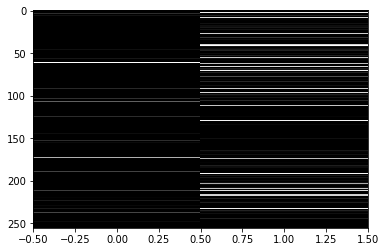

In [120]:
norm_activations = f_activations[0].t() * ((1 / f_activations[0].max(dim=1).values))
plt.imshow(norm_activations.detach().numpy(), aspect='auto', cmap='Greys_r')

In [144]:
g_activations = torch.stack([mid_res[f'identity_gc{i}'].view(-1, 64 * 64 * 256) for i in range(0, 4)], dim=1)

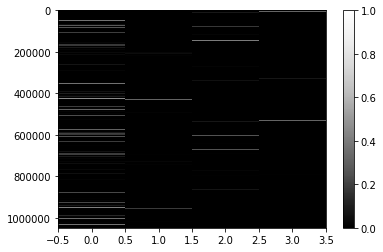

In [145]:
norm_activations_g = g_activations[0].t() * ((1 / g_activations[0].max(dim=1).values))
plt.imshow(norm_activations_g.detach().numpy(), aspect='auto', cmap='Greys_r')
plt.colorbar()

In [146]:
(g_activations[0] == 0).sum(dim=1)

tensor([ 782359,  943729,  982908, 1036209])

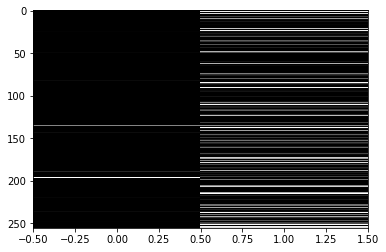

In [121]:
norm_activations2 = f_activations[1].t() * ((1 / f_activations[1].max(dim=1).values))
plt.imshow(norm_activations2.detach().numpy(), aspect='auto', cmap='Greys_r')

In [46]:
X_embedded = TSNE(n_components=2).fit_transform(torch.cat([all_res[qtype]['mha_gc1'] for qtype in qtypes]))

In [36]:
X_embedded

array([[ 153.93373 ,  129.25932 ],
       [ 207.70412 ,  -33.28526 ],
       [ -17.270176,  128.3473  ],
       [ -69.30714 ,  -34.757526],
       [  68.95953 ,   10.983522],
       [  69.73261 , -134.65114 ]], dtype=float32)

In [56]:
%matplotlib notebook

In [58]:
from matplotlib.cm import get_cmap

tab20 = get_cmap('tab20').colors

<IPython.core.display.Javascript object>


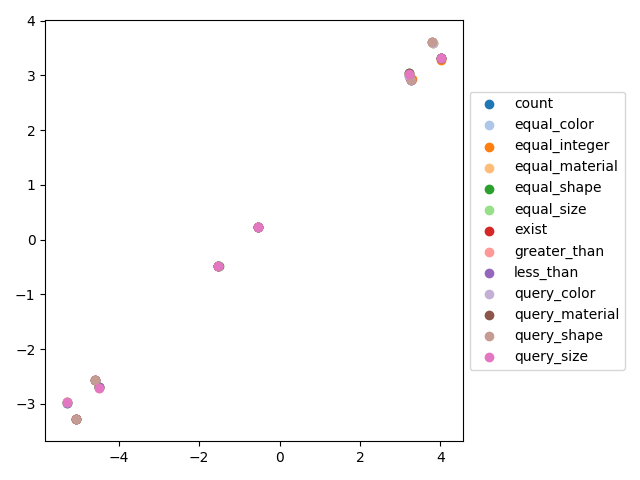

In [65]:
for i, qtype in enumerate(qtypes):
    plt.scatter(
        X_embedded[i * 6:(i + 1) * 6, 0], X_embedded[i * 6:(i + 1) * 6, 1],
        c=[tab20[i]],
        label=qtype,
    )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import os
import json
import pickle
import torch
import numpy as np
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from attrdict import AttrDict

from model import RN
from model_vanilla import RN as RNVanilla
from viz_utils import init_selected_datasets, load_model, compute_mid_results, get_all_metrics, mha_keys, identity_keys, plot_masks_per_qtype, plot_masks_histograms, _get_mask_metrics


device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
print(torch.cuda.device_count())
device

1


device(type='cuda', index=0)

In [48]:
selected_ds_per_qtype, dictionaries = init_selected_datasets(
    '/mnt/nas2/GrimaRepo/datasets/CLEVR_v1.0',
    # '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/',
#     '/home/fcorencoret/RelationNetworks-CLEVR/questions/CLEVR_built_dictionaries.pkl',
    'viz/CLEVR_built_dictionaries.pkl',
    'viz/selected_idxs_per_qtype.json',
)

with open('config.json', 'r') as f:
    hyp = json.load(f)['hyperparams']['original-fp']
    
qtypes = list(selected_ds_per_qtype.keys())

args = AttrDict()
args.qdict_size = len(dictionaries[0])
args.adict_size = len(dictionaries[1])

==> using cached questions: questions/CLEVR_val_questions.pkl


In [4]:
hyp

{'state_description': False,
 'g_layers': [256, 256, 256, 256],
 'question_injection_position': 0,
 'f_fc1': 256,
 'f_fc2': 256,
 'dropout': 0.5,
 'lstm_hidden': 256,
 'lstm_word_emb': 32,
 'rl_in_size': 52}

In [106]:
# hyp['lstm_hidden'] = 128
model = load_model(
    RN(args, hyp),
    '/home/fcorencoret/RelationNetworks-CLEVR/Norm_L1_0.1_sb_0.5/best_weights.pth',
#     '/home/rmanterola/repos/dynamic-rn/nRelu_Norm_L1_0.1_sb_0.5/best_weights.pth',
#     data_parallel=False,
    device_ids=[device],
)

Supposing original DeepMind model


In [5]:
model_name = 'Norm L1 0.1 SB 0.5'
model_folder = 'Norm_L1_sb_0.5'
if not os.path.exists(f'images/{model_folder}'):
    os.makedirs(f'images/{model_folder}')

In [127]:
res = compute_mid_results(
    model,
    selected_ds_per_qtype,
    bsz=128,
    device=device,
    samples_per_qtype=1,
    with_identity=True,
    # with_attention=False,
)

In [128]:
import collections
res_mask = collections.OrderedDict({k : v for k,v in res.items() if ('question' not in k and 'answer' not in k)})
res_questions = collections.OrderedDict({k.replace('_question', '') : v for k,v in res.items() if 'question' in k})
res_answers = collections.OrderedDict({k.replace('_answer', '') : v for k,v in res.items() if 'answer' in k})

In [129]:
metrics = get_all_metrics(
    res_mask,
    # mha_names=[],
)

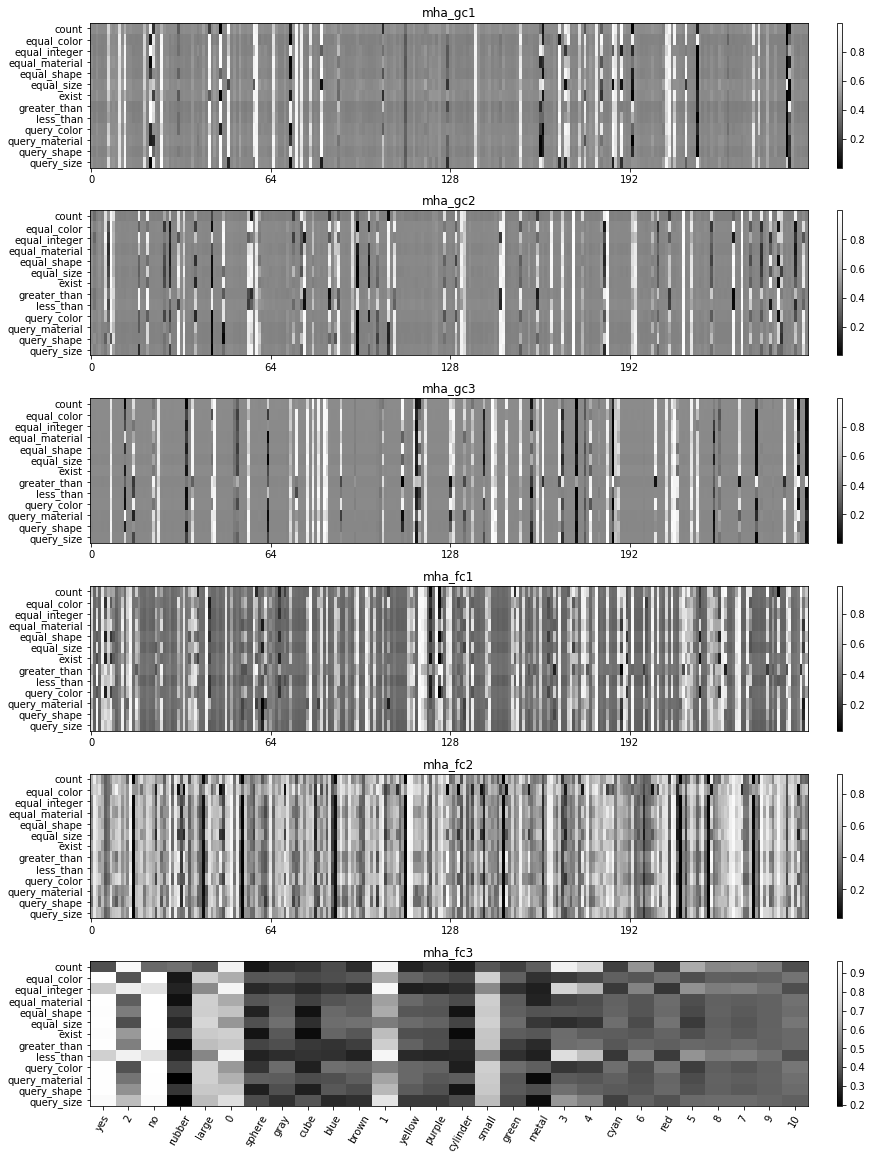

/home/rmanterola/virtualenv/RN/lib/python3.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [130]:
fig, axes = plot_masks_per_qtype(res_mask, adict=dictionaries[1])
# fig.suptitle(f'{model_name} - Mean Mask per Question')
fig.show()
# fig.savefig(f'images/{model_folder}/mean_mask_per_question.jpg', dpi=200)

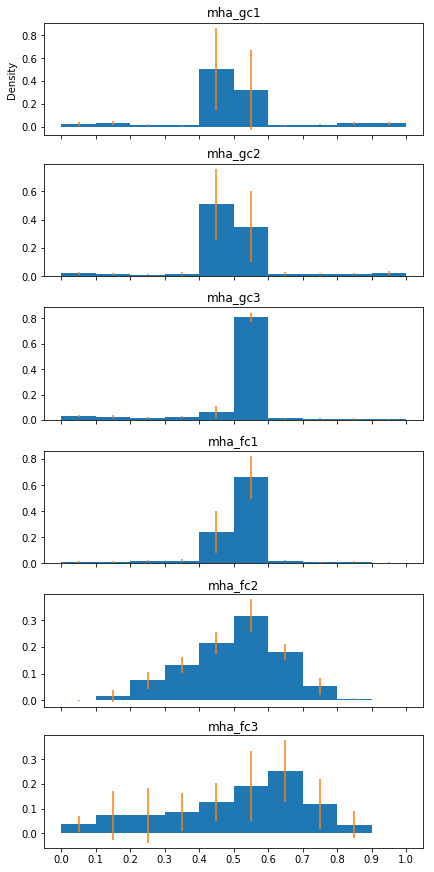

NameError: name 'model_name' is not defined

In [9]:
fig, axes = plot_masks_histograms(metrics['agg_metrics'])
fig.suptitle(f'{model_name} - Agg Masks Distribution')
axes[-1].set_xlabel('Mask value')
fig.show()
# fig.savefig(f'images/{model_folder}/agg_masks_distribution.jpg', dpi=200)

In [10]:
ssz = metrics['agg_metrics'][identity_keys[0]]['sparsity'].size(0)

sparsity_histograms = {
    identity_name: _get_mask_metrics(metrics['agg_metrics'][identity_name]['sparsity'].view(ssz, -1))
    for identity_name in identity_keys
}

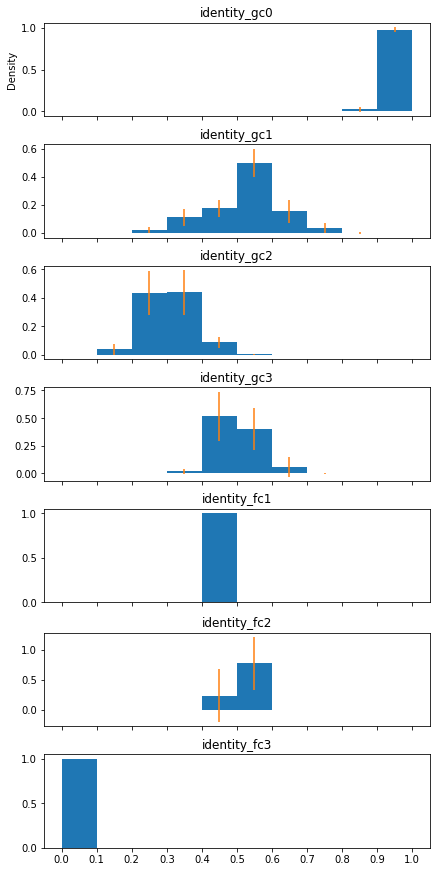

NameError: name 'model_name' is not defined

In [11]:
fig, axes = plot_masks_histograms(sparsity_histograms, keys=identity_keys)
fig.suptitle(f'{model_name} - Agg Activation Sparsity')
fig.show()
fig.savefig(f'images/{model_folder}/agg_activation_sparsity.jpg', dpi=200)

In [15]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import collections

In [109]:
q_dict = {v : k for k,v in dictionaries[0].items()}
a_dict = {v : k for k,v in dictionaries[1].items()}

In [110]:
masks = collections.OrderedDict({'mha_gc1' : [], 'mha_gc2':[], 'mha_gc3':[], 'mha_fc1':[], 'mha_fc2':[], 'mha_fc3':[]})
questions, answers, category = [], [], []
for key, value in res_mask.items():
    masks['mha_gc1'].append(value['mha_gc1'])
    masks['mha_gc2'].append(value['mha_gc2'])
    masks['mha_gc3'].append(value['mha_gc3'])
    masks['mha_fc1'].append(value['mha_fc1'])
    masks['mha_fc2'].append(value['mha_fc2'])
    masks['mha_fc3'].append(value['mha_fc3'])
    for b in res_questions[key]:
        for q in b: 
            string = ''
            for word in q: 
                if word.item() != 0: string += q_dict[word.item()] + ' ' 
                else: break
            questions.append([string])
            category.append(key)
        
    for b in res_answers[key]:
        for q in b: answers.append(a_dict[q.item()])
            
masks['mha_gc1'] = np.stack(masks['mha_gc1']).reshape(-1, 256)
masks['mha_gc2'] = np.stack(masks['mha_gc2']).reshape(-1, 256)
masks['mha_gc3'] = np.stack(masks['mha_gc3']).reshape(-1, 256)
masks['mha_fc1'] = np.stack(masks['mha_fc1']).reshape(-1, 256)
masks['mha_fc2'] = np.stack(masks['mha_fc2']).reshape(-1, 256)
masks['mha_fc3'] = np.stack(masks['mha_fc3']).reshape(-1, 28)


In [31]:
def scatter(plt, key, value):
    x_embedded = TSNE(n_components=2, perplexity=50).fit_transform(value)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=clusters)
    plt.title.set_text(key)

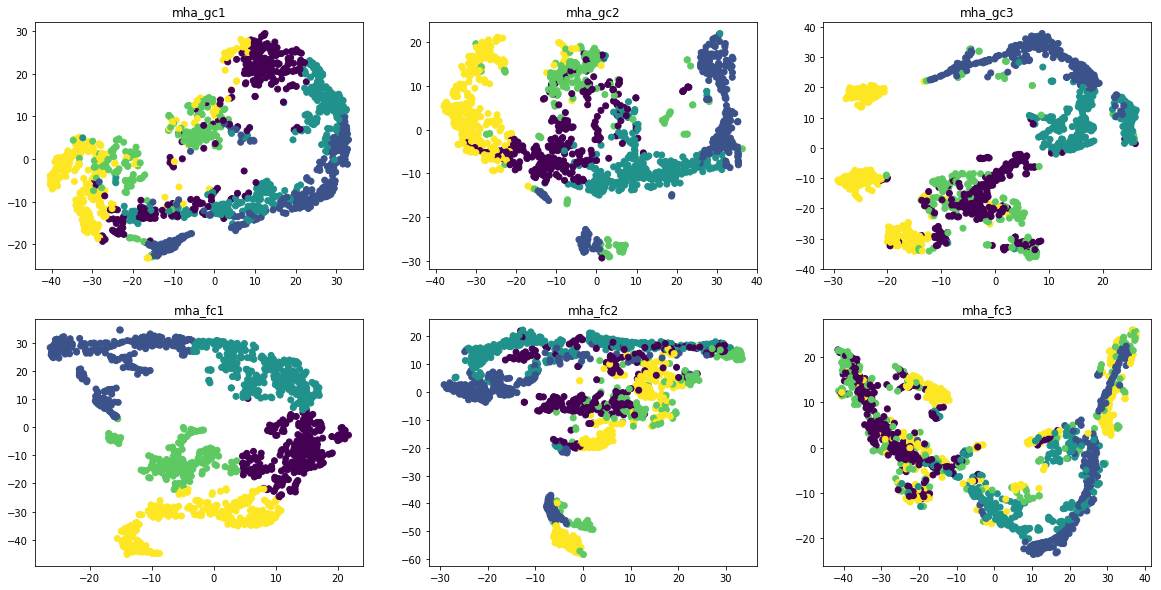

In [126]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
row, col = 0,0
for key,value in masks.items():
    scatter(ax[row][col], key, value)
    col += 1
    if col > 2:
        col = 0
        row+=1

In [111]:
x_embedded = TSNE(n_components=2, perplexity=50).fit_transform(masks['mha_fc1'])

In [112]:
clusters = KMeans(n_clusters=5, random_state=0).fit_predict(x_embedded)
# clusters = DBSCAN(eps=5, min_samples=3).fit_predict(x_embedded)
clusters

array([2, 2, 1, ..., 1, 1, 2], dtype=int32)

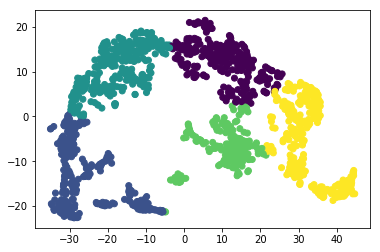

In [113]:
# x_embedded = TSNE(n_components=2, perplexity=50).fit_transform(masks['mha_fc3'])
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=clusters)

In [114]:
a = list(zip(questions, answers, clusters, category))

In [115]:
quest_clusters = []
for i in range(8):
    quest_clusters.append([x for x in a if x[2]==i])


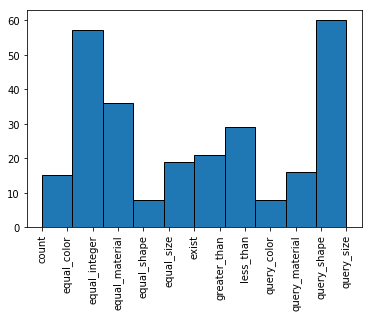

In [116]:
plt.hist([z[3] for z in quest_clusters[0]],ec = 'black')
plt.xticks(rotation='vertical')
plt.show()

In [117]:
quest_clusters[0]

[(['how many big balls are both behind the brown sphere and to the left of the big yellow metallic object ? '],
  '1',
  0,
  'count'),
 (['what number of cylinders are both right of the blue rubber block and behind the small cylinder ? '],
  '1',
  0,
  'count'),
 (['what number of shiny blocks are on the left side of the tiny metallic thing in front of the cyan ball ? '],
  '0',
  0,
  'count'),
 (['what number of things are tiny cyan balls or metal objects that are in front of the cyan ball ? '],
  '2',
  0,
  'count'),
 (['what number of things are both on the left side of the purple ball and to the right of the shiny thing ? '],
  '2',
  0,
  'count'),
 (['how many objects are things that are behind the big rubber thing or tiny rubber cylinders right of the big block ? '],
  '6',
  0,
  'count'),
 (['what number of objects are in front of the yellow matte sphere and on the left side of the metal thing ? '],
  '2',
  0,
  'count'),
 (['how many large purple blocks are to the right 

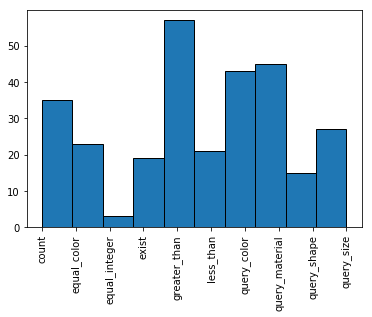

In [118]:
plt.hist([z[3] for z in quest_clusters[1]],ec = 'black')
plt.xticks(rotation='vertical')
plt.show()

In [119]:
quest_clusters[1]

[(['how many brown things are big rubber balls or metallic cylinders ? '],
  '3',
  1,
  'count'),
 (['how many purple matte blocks are there ? '], '1', 1, 'count'),
 (['how many green objects are either tiny things or tiny spheres ? '],
  '1',
  1,
  'count'),
 (['how many purple objects are either things or large objects ? '],
  '1',
  1,
  'count'),
 (['how many spheres are purple things or blue objects ? '], '0', 1, 'count'),
 (['how many blocks are large green matte things or tiny purple objects ? '],
  '2',
  1,
  'count'),
 (['how many small things are either blue rubber objects or cyan balls ? '],
  '1',
  1,
  'count'),
 (['how many matte things have the same size as the gray metallic block ? '],
  '2',
  1,
  'count'),
 (['what number of blocks are tiny rubber objects or large metallic objects ? '],
  '2',
  1,
  'count'),
 (['what number of spheres are tiny cyan things or tiny red things ? '],
  '0',
  1,
  'count'),
 (['what number of large objects are cyan cubes or purple 

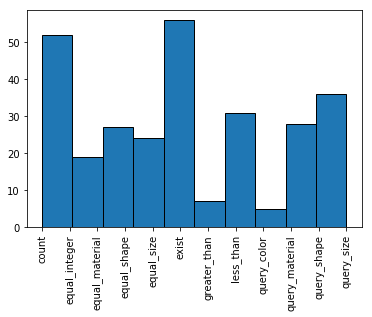

In [120]:
plt.hist([z[3] for z in quest_clusters[2]],ec = 'black')
plt.xticks(rotation='vertical')
plt.show()

In [121]:
quest_clusters[2]

[(['what number of other things are there of the same shape as the tiny matte object ? '],
  '2',
  2,
  'count'),
 (['how many other things are there of the same material as the big thing ? '],
  '2',
  2,
  'count'),
 (['how many other things are there of the same material as the purple cylinder ? '],
  '3',
  2,
  'count'),
 (['how many other small green metallic things are the same shape as the tiny thing ? '],
  '0',
  2,
  'count'),
 (['how many other objects are there of the same color as the large rubber cylinder ? '],
  '1',
  2,
  'count'),
 (['what number of objects are tiny metallic things in front of the brown shiny ball or green things ? '],
  '2',
  2,
  'count'),
 (['what number of other objects are the same shape as the large gray object ? '],
  '1',
  2,
  'count'),
 (['how many things are large blue spheres or large things that are to the left of the yellow block ? '],
  '3',
  2,
  'count'),
 (['what number of objects are cylinders in front of the tiny blue rubber s

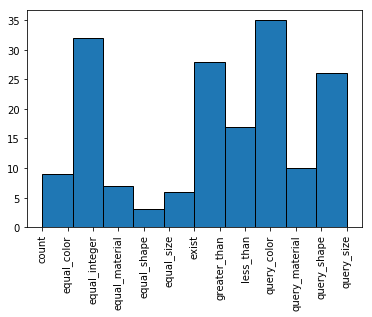

In [122]:
plt.hist([z[3] for z in quest_clusters[3]],ec = 'black')
plt.xticks(rotation='vertical')
plt.show()

In [123]:
quest_clusters[3]

[(['there is a big metallic object in front of the sphere to the right of the small purple rubber thing ; what number of things are behind it ? '],
  '2',
  3,
  'count'),
 (['there is a metal cylinder that is right of the large yellow object that is behind the small cyan sphere ; how many small rubber objects are on the right side of it ? '],
  '2',
  3,
  'count'),
 (['there is a brown block that is behind the sphere on the right side of the large yellow matte object ; what number of gray objects are in front of it ? '],
  '1',
  3,
  'count'),
 (['how many objects are small things that are on the right side of the tiny purple metallic cylinder or tiny red metal objects in front of the tiny metal sphere ? '],
  '6',
  3,
  'count'),
 (['does the big metallic object that is to the left of the big green metallic thing have the same color as the cylinder in front of the large metallic cylinder ? '],
  'yes',
  3,
  'equal_color'),
 (['there is a large thing that is on the right side of 

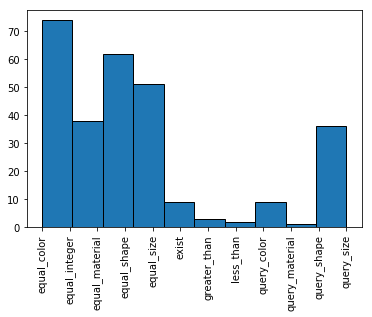

In [124]:
plt.hist([z[3] for z in quest_clusters[4]],ec = 'black')
plt.xticks(rotation='vertical')
plt.show()

In [125]:
quest_clusters[4]

[(['is the color of the object to the left of the small sphere the same as the cylinder right of the purple thing ? '],
  'no',
  4,
  'equal_color'),
 (['does the matte object behind the gray metallic ball have the same color as the big rubber sphere ? '],
  'yes',
  4,
  'equal_color'),
 (['do the big rubber cube that is behind the small rubber cube and the large matte cylinder have the same color ? '],
  'no',
  4,
  'equal_color'),
 (['is the color of the large rubber object on the left side of the yellow rubber ball the same as the metal ball ? '],
  'no',
  4,
  'equal_color'),
 (['is the color of the small thing that is in front of the blue thing the same as the cube ? '],
  'no',
  4,
  'equal_color'),
 (['is the color of the small matte block the same as the block that is right of the large matte thing ? '],
  'no',
  4,
  'equal_color'),
 (['is the color of the small matte object the same as the tiny metal thing that is behind the big metal sphere ? '],
  'yes',
  4,
  'equal

In [40]:
quest_clusters[5]

[]

In [28]:
quest_clusters[6]

[(['what number of shiny blocks are on the left side of the tiny metallic thing in front of the cyan ball ? '],
  '0'),
 (['what number of things are both on the left side of the purple ball and to the right of the shiny thing ? '],
  '2'),
 (['there is a big metallic object in front of the sphere to the right of the small purple rubber thing ; what number of things are behind it ? '],
  '2'),
 (['how many objects are things that are behind the big rubber thing or tiny rubber cylinders right of the big block ? '],
  '6'),
 (['what number of objects are in front of the yellow matte sphere and on the left side of the metal thing ? '],
  '2'),
 (['how many large objects are both in front of the green shiny cylinder and on the right side of the large green rubber object ? '],
  '3'),
 (['how many objects are small things that are on the right side of the tiny purple metallic cylinder or tiny red metal objects in front of the tiny metal sphere ? '],
  '6'),
 (['how many things are either th

In [29]:
quest_clusters[7]

[(['how many other things are there of the same material as the big thing ? '],
  '2'),
 (['how many brown things are big rubber balls or metallic cylinders ? '],
  '3'),
 (['how many other things are there of the same material as the purple cylinder ? '],
  '3'),
 (['how many green objects are either tiny things or tiny spheres ? '], '1'),
 (['how many purple objects are either things or large objects ? '], '1'),
 (['how many spheres are purple things or blue objects ? '], '0'),
 (['how many blocks are large green matte things or tiny purple objects ? '],
  '2'),
 (['how many small things are either blue rubber objects or cyan balls ? '],
  '1'),
 (['how many matte things have the same size as the gray metallic block ? '],
  '2'),
 (['what number of blocks are tiny rubber objects or large metallic objects ? '],
  '2'),
 (['what number of matte objects are small gray objects or yellow cylinders ? '],
  '0'),
 (['what number of spheres are tiny cyan things or tiny red things ? '], '0'),